
# Using census Data to predict income



## William Thomas

# Overview

###  From a census in 1994, we have collected data of just under 50,000 people. 

###  Features include: age, work class, education, marital status, final weight (see below) occupation, relationship to the homeowner, race, sex, capital gain and loss, hours per week, native country and salary.

### Here we want to use the salary as a dependant variable, to see how it depends on all the other features, this will be a binary outcome where we want to make a predictive model if someone earns above 50,000 dollars per year or not. We will use predictive analysis to determine this.

## According to the census data, this is how final weight is described:

Description of fnlwgt (final weight)

 The weights on the CPS files are controlled to independent estimates of the
 civilian noninstitutional population of the US.  These are prepared monthly
 for us by Population Division here at the Census Bureau.  We use 3 sets of
 controls.
  These are:
          1.  A single cell estimate of the population 16+ for each state.
          2.  Controls for Hispanic Origin by age and sex.
          3.  Controls by Race, age and sex.

# The analysis 
- Done in python
- We first use a training set to train the model before using it on the testing data.
- I will call these datasets "test" and "train" respectively

# The first thing we do in python is to import the packages we will use, then import the data.

In [1]:
#import data packages
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
#import graph packages
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

#Import the data
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
train = pd.read_csv(train_url)

test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
#the first row is skipped because there wasn't a data entry.
test = pd.read_csv(test_url, names =["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", 
                 "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"], skiprows=1)
 

# Next we clean the data by filling out missing values and converting any strings to numeric values for the model to be able to read.

In [2]:
#Cleaning data and converting attributes to integer forms 

# First thing is to add the titles for each column
train.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", 
                 "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]




# Data has some question marks '?' replace with NaN 
train= train.replace('[?]', np.nan, regex=True) 
# Check columns with NaN
train_nans = train.isnull().sum()
#print(train_nans)





# Train NaNs in workclass, occupation and native-country so we can fill these with the most common entries, to find this out use .value_counts()
# print(train["workclass"].value_counts())
# print(train["occupation"].value_counts())
# print(train["native-country"].value_counts())




# Looking at this the most common things are: workclass - private, occupation native-country - United-States
train["workclass"] = train["workclass"].fillna("Private")
train["native-country"] = train["native-country"].fillna("United-States")

# also notice how the non US countries are very small and scattered, would be more efficient to group them up
train.loc[train['native-country']!=' United-States','native-country'] = 'non_us'
#print(train["native-country"].value_counts())


# Workclass is varied, so reindexing will give a better representation
train["occupation"] = train["occupation"].fillna(method='ffill')





#Check NaNs are filled
#train_nans_2 = train.isnull().sum()
#print(train_nans_2)

# Before we convert the text to integers, we can make some of our own observations.

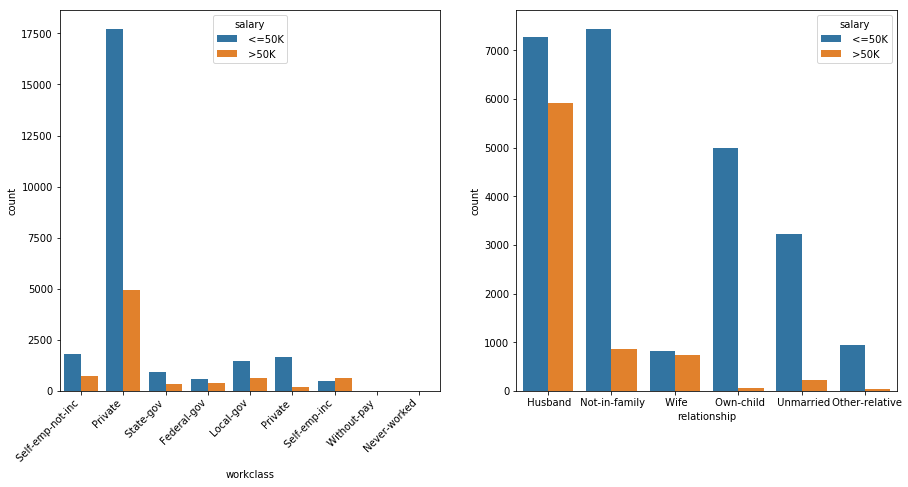

In [3]:
fig, ((a,b)) = plt.subplots(1,2,figsize=(15,7))
p = sns.countplot(train['workclass'],hue=train['salary'],ax=a)
p.set_xticklabels(p.get_xticklabels(), rotation=45, ha="right")
sns.countplot(train['relationship'],hue=train['salary'],ax=b)

[Text(0,0,' White'),
 Text(0,0,' Black'),
 Text(0,0,' Asian-Pac-Islander'),
 Text(0,0,' Amer-Indian-Eskimo'),
 Text(0,0,' Other')]

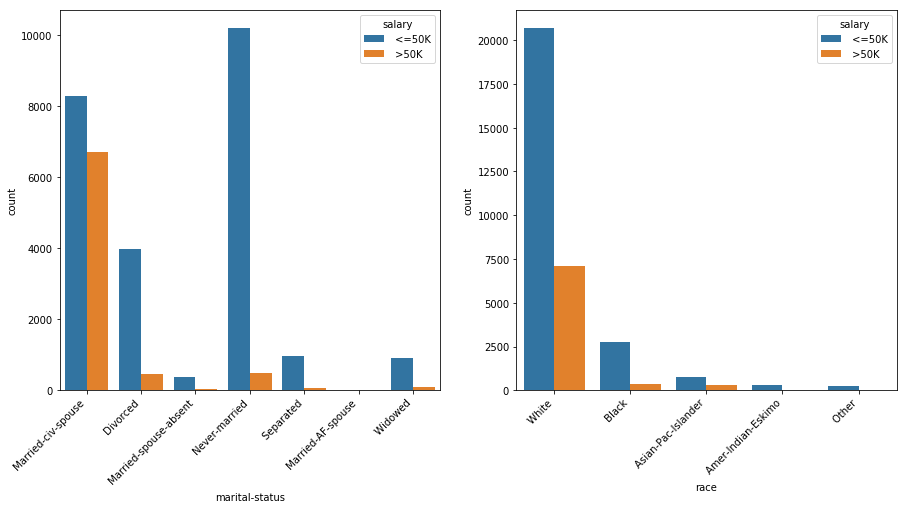

In [4]:
fig, ((c,d)) = plt.subplots(1,2,figsize=(15,7))
q = sns.countplot(train['marital-status'],hue=train['salary'],ax=c)
q.set_xticklabels(q.get_xticklabels(), rotation=45, ha="right")
r = sns.countplot(train['race'],hue=train['salary'],ax=d)
r.set_xticklabels(r.get_xticklabels(), rotation=45, ha="right")

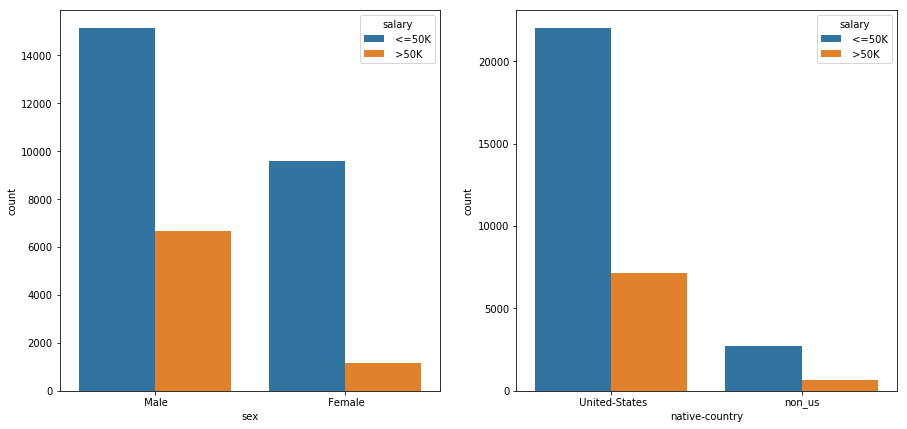

In [5]:
fig, ((e,f)) = plt.subplots(1,2,figsize=(15,7))
sns.countplot(train['sex'],hue=train['salary'],ax=e)
sns.countplot(train['native-country'],hue=train['salary'],ax=f)

# Some observations:

### You are slightly more likely to earn above 50k if you are:

- Native to the US.
- In the white or asian/pacific islander category.
- Male
- Work in the private sector 

### You are much more likely to earn above 50k if you are: 

- Married
- Self employed

In [6]:
# Converting strings to integer form in the following: sex, workclass, marital-status, occupation, race, native-country
train = train.replace(["Male", "Female"], [0, 1], regex = True)
#print(train["sex"])
train = train.replace(["Private", "Self-emp-not-inc", "Self-emp-inc", 
     "Federal-gov", "Local-gov", "State-gov","Without-pay","Never-worked"], [0, 1, 2, 3, 4, 5, 6, 7], regex=True)
#print(train["workclass"])
train = train.replace(["Married-civ-spouse", "Divorced", "Never-married", 
                       "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse"], [0, 1, 2, 3, 4, 5, 6], regex=True)
#print(train["marital-status"])
train = train.replace(["Wife", "Own-child", "Husband", 
                       "Not-in-family", "Other-relative", "Unmarried"], [0, 1, 2, 3, 4, 5], regex=True)
#print(train["relationship"])

train = train.replace(["Tech-support", "Craft-repair", "Other-service", "Sales", "Exec-managerial", "Prof-specialty", 
                       "Handlers-cleaners", "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", 
                       "Priv-house-serv", "Protective-serv", "Armed-Forces"], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                        regex=True)

#print(train["occupation"])
train = train.replace(["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"], [0, 1, 2, 3, 4], regex=True)
#print(train["race"])
train = train.replace(["United-States", "non_us"], [0, 1], regex=True)
#print(train["native-country"].value_counts())
train = train.replace(["<=50K", ">50K"], [0, 1], regex = True)
#print(train["salary"])

# Now we make our predictive models. I chose to use:

### Decision tree classifier:
- Makes predicitions on a target category based on chosen features
- Each feature is weighed in its importance and is used to make the decision.

### Random forest classifier:
- Creates a lot of decision trees and uses a voting system to make the decision.
- For example if the forest contained 21 trees and 11 trees said yes and 10 trees said no, it will decide with yes.

In [9]:
# We create our target - our dependant variable and features - our independant variables
target = train["salary"].values
features_one = train[["age", "workclass", "fnlwgt", "education-num", "marital-status", "relationship", "occupation", "race", "sex", 
                 "capital-gain", "capital-loss", "hours-per-week", "native-country"]].values

#Now all the relavent columns are in number form, we can start building the decision tree
my_tree_one = tree.DecisionTreeClassifier(max_depth = 15, min_samples_split = 5, random_state = 1)
my_tree_one = my_tree_one.fit(features_one, target)

# Look at the importance and score of the included features
print(my_tree_one.feature_importances_)
print(my_tree_one.score(features_one, target))

[ 0.07624129  0.02014369  0.07390959  0.17963875  0.32053478  0.00937682
  0.0363087   0.00595901  0.00398678  0.15913129  0.05867775  0.0520882
  0.00400336]
0.900675675676


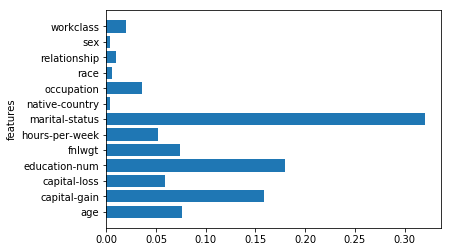

In [20]:
bar_features = ["age", "workclass", "fnlwgt", "education-num", "marital-status", "relationship", "occupation", "race", "sex", 
                 "capital-gain", "capital-loss", "hours-per-week", "native-country"]
plt.barh(bar_features, my_tree_one.feature_importances_)
plt.ylabel("features")
plt.show()

## So what we can observe from this decision tree is that it takes the education, marital status and capital gain as its most important features, and it returns a mean accuracy of 90%

## Now that the model is trained, we can use it on our testing data and observe how accurate it is, first we will clean the test data (in notes)

## After cleaning, we can use the model to make a prediction and then compare it with the actualy results

In [21]:

test= test.replace('[?]', np.nan, regex=True) 
#test_nans = test.isnull().sum()
#print(test_nans)
test["workclass"] = test["workclass"].fillna("Private")
test["native-country"] = test["native-country"].fillna("United-States")

# also notice how the non US countries are very small and scattered, would be more efficient to group them up
test.loc[test['native-country']!=' United-States','native-country'] = 'non_us'
#print(train["native-country"].value_counts())


# Workclass is varied, so reindexing will give a better representation
test["occupation"] = test["occupation"].fillna(method='ffill')
#test_nans2 = test.isnull().sum()
#print(test_nans2)

# Converting strings to integer form in the following: sex, workclass, marital-status, occupation, race, native-country
test = test.replace(["Male", "Female"], [0, 1], regex = True)
test = test.replace(["Private", "Self-emp-not-inc", "Self-emp-inc", 
     "Federal-gov", "Local-gov", "State-gov","Without-pay","Never-worked"], [0, 1, 2, 3, 4, 5, 6, 7], regex=True)
test = test.replace(["Married-civ-spouse", "Divorced", "Never-married", 
                       "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse"], [0, 1, 2, 3, 4, 5, 6], regex=True)
test = test.replace(["Wife", "Own-child", "Husband", 
                       "Not-in-family", "Other-relative", "Unmarried"], [0, 1, 2, 3, 4, 5], regex=True)
test = test.replace(["Tech-support", "Craft-repair", "Other-service", "Sales", "Exec-managerial", "Prof-specialty", 
                       "Handlers-cleaners", "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", 
                       "Priv-house-serv", "Protective-serv", "Armed-Forces"], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                        regex=True)
test = test.replace(["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"], [0, 1, 2, 3, 4], regex=True)
test = test.replace(["United-States", "non_us"], [0, 1], regex=True)
test = test.replace(["<=50K", ">50K"], [0, 1], regex = True)


In [22]:
# Create test features with the same features from training set
test_features = test[["age", "workclass", "fnlwgt", "education-num", "marital-status", "relationship", "occupation", "race", "sex", 
                 "capital-gain", "capital-loss", "hours-per-week", "native-country"]].values

# Make a prediction algorithm
my_prediction = my_tree_one.predict(test_features)
#print(my_prediction)
#Create a data frame
solution = my_prediction - test["salary"]
solution = solution.replace(-1, 1)
true_false = solution.value_counts().tolist()
accuracy = (true_false[0] - true_false[1])/true_false[0]
print(accuracy)

0.8192762346798173


## As you can see the accuracy returned is around 82%, which isn't bad! we can now observe if the forest classifier returns different results

In [23]:
# build the forest
my_forest = RandomForestClassifier(max_depth = 6, min_samples_split=2, n_estimators = 100, random_state = 0, oob_score =True)
my_forest = my_forest.fit(features_one, target)

# Look at the importance and score of the included features
print(my_forest.feature_importances_)
print(my_forest.score(features_one, target))


[ 0.07934023  0.00872221  0.00276419  0.17131964  0.29926843  0.08615445
  0.03949967  0.00218799  0.02021795  0.20928673  0.03816654  0.04206642
  0.00100553]
0.856265356265


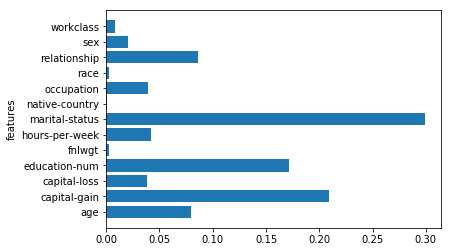

In [24]:
bar_features = ["age", "workclass", "fnlwgt", "education-num", "marital-status", "relationship", "occupation", "race", "sex", 
                 "capital-gain", "capital-loss", "hours-per-week", "native-country"]
plt.barh(bar_features, my_forest.feature_importances_)
plt.ylabel("features")
plt.show()

##  The most important features are kept the same in our forest algorithm but the mean accuracy appears to be slightly lower than the decision tree.

In [63]:
# Make another prediction algorithm
my_prediction_2 = my_forest.predict(test_features)
#print(my_prediction_2)
#Create another data frame
solution_2 = my_prediction_2 - test["salary"]
solution_2 = solution_2.replace(-1, 1)
true_false_2 = solution_2.value_counts().tolist()
accuracy_2 = (true_false_2[0] - true_false_2[1])/true_false_2[0]
print(accuracy_2)

0.8316469321851453


## We get a better accuracy in the testing data of around 83%!

# Thank you

## Q&A